# Global imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import Counter

from qksvm.QuantumFeatureMap import QuantumFeatureMap
from qksvm.QKSVM import QSVC
from qksvm.visualization_tools import plot_dataset, plot_predictions

seed = 1234

# Dataset

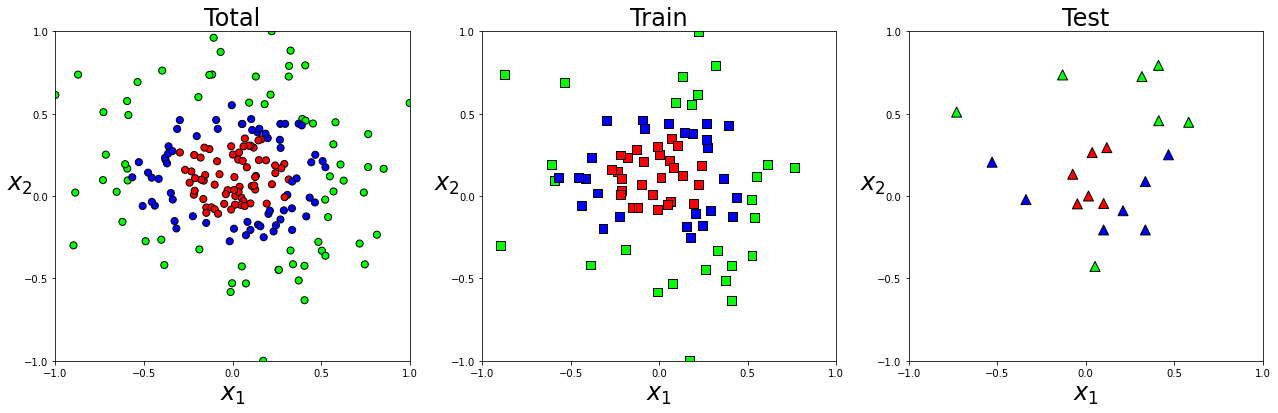

(200, 2) (200,)


In [2]:
# Sklearn imports
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.datasets import make_gaussian_quantiles
np.random.seed(seed)

# Total number of the dataset points
n_samples = 200
X, y = make_gaussian_quantiles(n_samples=n_samples, n_features=2, n_classes=3, shuffle=True, random_state=seed)
y = 2*y-1 # rescale to [-1,1]

# Data rescaling
xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax), copy=False).fit_transform(X)

train_size = 80
test_size = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=train_size, 
                                                    test_size=test_size,
                                                    stratify=y,
                                                    random_state=seed)

# Visualize the dataset
plot_colors = ['#FF0000', '#0000FF', '#00FF00']
cmap = ListedColormap(plot_colors)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes, cmap=cmap)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80, cmap=cmap)

ax3.set_title("Test", fontsize=24)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100, cmap=cmap)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

print(X.shape, y.shape)

# RBF SVM

## Training

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 10, 20, 40, 60, 80, 100, 1000],
}

gs = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=seed),
)
gs.fit(X_train, y_train)
clf = gs.best_estimator_

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)

print('\nTrain set:')
y_pred = clf.predict(X_train)
print(metrics.classification_report(y_train, y_pred))
print(metrics.confusion_matrix(y_train, y_pred))

print('\nTest set:')
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

Best grid search parameters: {'C': 10, 'gamma': 5.0}
Best training score: 0.9126984126984128

Train set:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        27
           1       1.00      0.96      0.98        26
           3       0.96      1.00      0.98        27

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

[[27  0  0]
 [ 0 25  1]
 [ 0  0 27]]

Test set:
              precision    recall  f1-score   support

          -1       0.86      1.00      0.92         6
           1       0.71      0.71      0.71         7
           3       0.83      0.71      0.77         7

    accuracy                           0.80        20
   macro avg       0.80      0.81      0.80        20
weighted avg       0.80      0.80      0.80        20

[[6 0 0]
 [1 5 1]
 [0 2 5]]


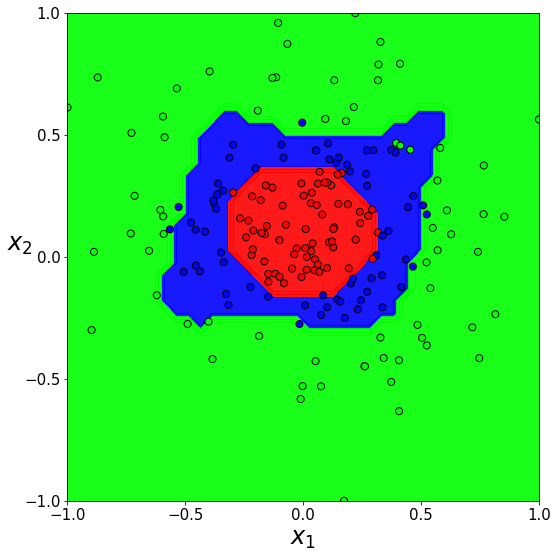

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

plot_predictions(clf, ax, axes, N=40, cmap=cmap)
plot_dataset(X, y, ax, axes, cmap=cmap)

plt.tight_layout()
plt.show()

# QSVM

In [5]:
## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=1,
    gates=['H', 'RZ', 'CZ', ], entanglement='linear',
)
print(fm.draw(plot_barriers=False, fold=120))

     ┌───┐ ┌────────────┐     
q_0: ┤ H ├─┤ Rz(x[0]*α) ├──■──
     ├───┤ ├────────────┤  │  
q_1: ┤ H ├─┤ Rz(x[1]*α) ├──■──
     └───┘ └────────────┘     


In [6]:
# Training the model
param_grid = {
    "alpha": [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0],
    "C": [1, 10, 20, 40, 60, 80, 100, ],
}

np.random.seed(seed)

gs = GridSearchCV(
    estimator=QSVC(fm, alpha=2.0, C=20, random_state=seed),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=seed),
)

gs.fit(X_train, y_train)
clf = gs.best_estimator_

print('Best grid search parameters:', gs.best_params_)
idx = np.where(gs.cv_results_["rank_test_score"]==1)[0][0]
print('Best training CV scores', 
      gs.cv_results_["mean_test_score"][idx], '+-', gs.cv_results_["std_test_score"][idx])

print('\nTrain set:')
y_pred = clf.predict(X_train)
print(metrics.classification_report(y_train, y_pred))
print(metrics.confusion_matrix(y_train, y_pred))

print('\nTest set:')
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

Best grid search parameters: {'C': 40, 'alpha': 2.6}
Best training CV scores 0.9246031746031746 +- 0.039082769054746454

Train set:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        27
           1       1.00      0.92      0.96        26
           3       0.93      1.00      0.96        27

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80

[[27  0  0]
 [ 0 24  2]
 [ 0  0 27]]

Test set:
              precision    recall  f1-score   support

          -1       0.86      1.00      0.92         6
           1       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         7

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

[[6 0 0]
 [1 6 0]
 [0 0 7]]


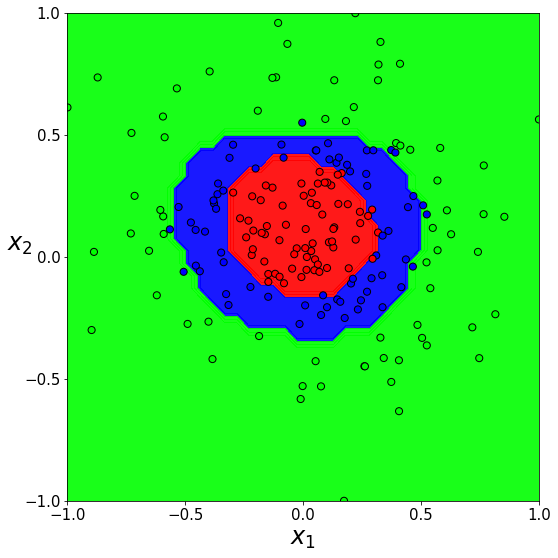

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

plot_predictions(clf, ax, axes, N=40, cmap=cmap)
plot_dataset(X, y, ax, axes, cmap=cmap)

plt.tight_layout()
plt.show()